# Minería de texto

Análisis de sentimientos en el texto

## Imports

In [1]:
import numpy as np
import pandas as pd
import gzip
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from urllib.request import urlretrieve

Vamos a ejecutar el siguiente código para descargar el conjunto de datos.

Tenemos un conjunto de datos de revisiones y comentarios a suscripciones de revistas en Amazon.com

El conjunto de datos constará de 26115 opiniones, etiquetadas con entre 1 y 5 estrellas (atributo ```overall```).

El texto de cada comentario está en el atributo ```reviewText```

In [2]:
#@title Ejecutar esta celda para descargar base de datos

def download(file, url):
    if not os.path.exists(file):
        urlretrieve(url, file)

def parse(path):
  gzip_file = gzip.open(path, 'rb')
  for file_line in gzip_file:
    yield json.loads(file_line)

def getDF(path):
  index = 0
  df = {}
  for entry in parse(path):
    df[index] = entry
    index += 1
  return pd.DataFrame.from_dict(df, orient='index')


download("Magazine_Subscriptions.json.gz", "https://www.dropbox.com/s/g6om8q8c8pvirw8/Magazine_Subscriptions.json.gz?dl=1")
nltk.download("punkt")

data = getDF('Magazine_Subscriptions.json.gz')

rus = RandomUnderSampler(random_state=42)
data, _ = rus.fit_resample(data, data["overall"])

# Cast the review text type in order to be able to use it with sklearn later
data["reviewText"] = data["reviewText"].values.astype('U')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gdrot\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [3]:
data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
57755,1.0,22,False,"08 14, 2007",A2P7ETBL7020DF,B000O1PKOG,Gary Smith,This magazine has a catchy title and very nice...,Just plain lame.,1187049600,{'Format:': ' Print Magazine'},NaN
12104,1.0,3,False,"01 9, 2014",AONC3Q7956CQ6,B00005N7T5,J-Lick,Before it was easy to go directly to the New Y...,Very Dissapointed in the on line format,1389225600,{'Format:': ' Kindle Edition'},NaN
44124,1.0,11,False,"09 7, 2009",A9004RLMUCQCJ,B00077B7M6,PT,I don't really understand why this product is ...,Extremely Expensive,1252281600,{'Format:': ' Kindle Edition'},NaN
70981,1.0,NaN,False,"10 9, 2015",A1DEYML4ZKN1WV,B00HG1BP0U,Angie,Looked nicer in the picture,One Star,1444348800,{'Format:': ' Print Magazine'},NaN
56361,1.0,NaN,True,"07 23, 2014",A3ULPJ814I5LP6,B000IOEK7M,John,Never received.,One Star,1406073600,NaN,NaN


**1)** Vamos a quedarnos solo con los atributos  ```reviewText``` and ```overall``` en un dataframe aparte





In [4]:
d = data[["reviewText", "overall"]]
d.head()

,reviewText,overall
57755,This magazine has a catchy title and very nice...,1.0
12104,Before it was easy to go directly to the New Y...,1.0
44124,I don't really understand why this product is ...,1.0
70981,Looked nicer in the picture,1.0
56361,Never received.,1.0


**2)** Veamos ahora la distribución de las estrellas ✴


<Axes: xlabel='overall'>

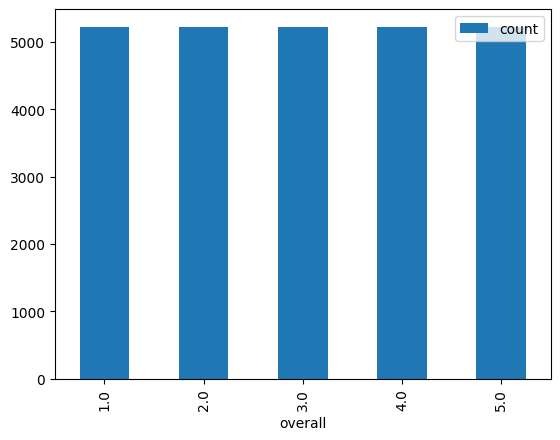

In [5]:
d.overall.value_counts().reset_index().plot.bar(x="overall", y="count")

Vemos que hay una misma cantidad de cada puntuación.

**3)** Como nuestro objetivo es poder predecir si un texto es positivo o negativo, utilizaremos las estrellas para determinar cual es el sentimiento del usuario.

Aquellos con 4 y 5 estrellas serán positivos, y aquellos con 1 y 2 estrellas serán negativos.

Eliminaremos los de 3 estrellas porque son neutrales y no nos aportan valor para la clasificación

In [6]:
d = d[d.overall != 3]

**4)** Ahora que tenemos la base de datos filtrada, vamos a agregar una columna  `label`  que nos indicará el sentimiento del comentarista. El valor sera `"pos"` para 4 y 5 estrellas, y  `"neg"` para 1 y 2 estrellas.

In [7]:
d["label"] = d.overall.map({1: "neg", 2: "neg", 4: "pos", 5: "pos"})
d.head()

,reviewText,overall,label
57755,This magazine has a catchy title and very nice...,1.0,neg
12104,Before it was easy to go directly to the New Y...,1.0,neg
44124,I don't really understand why this product is ...,1.0,neg
70981,Looked nicer in the picture,1.0,neg
56361,Never received.,1.0,neg


**5)** Hagamos el entrenamiento ahora... para ello separaremos el conjunto de datos en entrenamiento y prueba, manteniendo el mismo número de cada ejemplos de cada tipo de sentimiento en cada conjunto.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(d["reviewText"], d["label"], test_size=0.2, stratify=d["label"])

**6)** Ahora crearemos un vector tf.idf para el entrenamiento. Las palabras que aparezcan en menos de 3 documentos las vamos a eliminar, y vamos a usar palabras y bigramas.

In [9]:
model = TfidfVectorizer(min_df=3)
X_train_transformed = model.fit_transform(X_train)

**7)** Entrenaremos un modelo de clasificación para poder aprender cuando un texto es positivo y cuando es negativo.



In [10]:
lm = LogisticRegression()
lm.fit(X_train_transformed, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


**8)** Vamos a verificar que tan bien funciona

In [11]:
y_predict = lm.predict(model.transform(X_test))

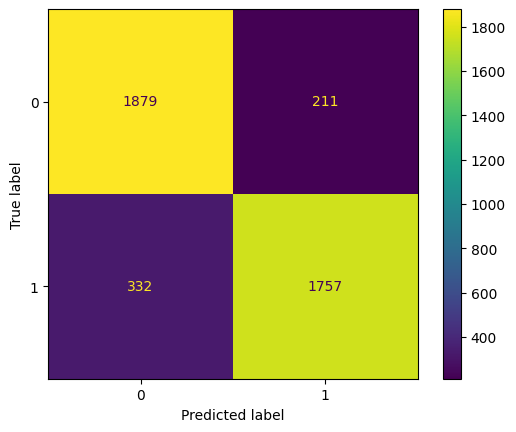

In [14]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)).plot()

In [15]:
data_comparison = {"x_test": X_test, "y_test": y_test, "y_predict": y_predict}
df_comparison = pd.DataFrame(data_comparison)
df_comparison.head()

,x_test,y_test,y_predict
60700,"Your ""Trump's Missing Emails"" cover is laughab...",neg,neg
65481,My son loves the Entertainment weekly.,pos,pos
86085,I was an avid subscriber to Worship Leader mag...,neg,neg
3327,I got the November 2010 copy of Reason and was...,neg,neg
18099,This is a valuable issue with excellent inform...,pos,pos


Veamos aquellos que fueron predichos de manera errónea

In [21]:
errors = df_comparison.loc[df_comparison['y_test'] != df_comparison['y_predict']]
errors.head()

,x_test,y_test,y_predict
19298,I don't feel the articles are as good as they ...,pos,neg
43193,I LOVE the cover of my first AP magazine (pani...,pos,neg
58945,It has interesting facts about lives of famous...,pos,neg
12739,stafff completely miss the magazine \'s mission!,neg,pos
33170,Great magazine. Articles not ads.,pos,neg


In [26]:
errors['x_test'].iloc[0]

"I don't feel the articles are as good as they used to be....but.....then...i don't always look at this for the articles."

Qué puede estar pasando que el clasificador se está equivocando???